# Importing dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy import sparse
from scipy.sparse import hstack,csr_matrix
import math

In [3]:
#importing the datasets
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

# Preprocessing and feature engineering


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

- Handling missing values:

In [5]:
missing_values=train_df.isnull().sum()
print(missing_values)

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [6]:
#removing rows that have the text missing
train_df.dropna(subset=['comment_text'], inplace=True)

In [7]:
def feature_engineering(df):
    df['length'] = df.comment_text.apply(lambda x: len(x))    #adding a length column ( length of a comment in characters)
    train_df['num_exclamations'] = train_df['comment_text'].apply(lambda x: x.count('!'))  #number of exclamations as it was found to be more in toxic comments in EDA
    return df
    

In [8]:
train_df=feature_engineering(train_df)
test_df=feature_engineering(test_df)

In [26]:
test_df['num_exclamations'] = test_df['comment_text'].apply(lambda x: x.count('!'))

In [9]:
train_df.head(1)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,length,num_exclamations
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0,0.0,0,4,101,1


In [27]:
test_df.head()

,id,comment_text,length,num_exclamations
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,0
1,7097321,This is malfeasance by the Administrator and t...,84,1
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,0
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,0
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,0


# Text preprocessing

In [10]:
nlp = spacy.load("en_core_web_sm")  #spacy's pipeline for english language, using it for lemmatization

- Lemmatization and stopwords removal

In [11]:
def preprocess(text_string):
    text_string = text_string.lower()
    text_string = re.sub(r'[^A-Za-z0-9]+', ' ', text_string) #Remove special characters and punctuations
    doc = nlp(text_string)
    new_text = []
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            new_text.append(token.lemma_)
    text_string = ' '.join(new_text)
    return text_string

In [12]:
tqdm.pandas()
train_df['preprocessed_text'] = train_df['comment_text'].progress_apply(preprocess)

100%|█████████████████████████████████████████████████████████████████████| 1804871/1804871 [4:30:45<00:00, 111.10it/s]


In [28]:
tqdm.pandas()
test_df['preprocessed_text'] = test_df['comment_text'].progress_apply(preprocess)

100%|███████████████████████████████████████████████████████████████████████████| 97320/97320 [13:45<00:00, 117.85it/s]


In [14]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,length,num_exclamations,preprocessed_text
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,101,1,cool s like want mother read great idea
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,114,3,thank life lot anxiety induce don t let way
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,86,1,urgent design problem kudo take impressive
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,84,0,ll able install site release
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,0,1,0,0.0,4,47,36,0,haha guy bunch loser


In [29]:
test_df.head()

,id,comment_text,length,num_exclamations,preprocessed_text
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,0,integrity mean pay debt apply president trump
1,7097321,This is malfeasance by the Administrator and t...,84,1,malfeasance administrator board waste money
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,0,rmiller101 speak like true elitist look bud ...
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,0,paul thank kind word strong belief don t hide ...
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,0,sorry miss high school eisenhower send troop v...


- saving the preprocessed datasets using Pickle

In [32]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

In [2]:
#read back the files later
train_df=pd.read_pickle('train_df.pkl')
test_df=pd.read_pickle('test_df.pkl')

In [3]:
train_df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,length,num_exclamations,preprocessed_text
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,101,1,cool s like want mother read great idea
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,114,3,thank life lot anxiety induce don t let way


# Training the Models

# 1. Bag of Words (BoW)
- without including the engineered features, to avoid unnecessary bias due to writing style.

In [4]:
feature = train_df[['preprocessed_text']]
output = train_df['target']
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

In [5]:
test_df.head(2)

,id,comment_text,length,num_exclamations,preprocessed_text
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,0,integrity mean pay debt apply president trump
1,7097321,This is malfeasance by the Administrator and t...,84,1,malfeasance administrator board waste money


In [6]:
X_test=test_df[['preprocessed_text']]

In [7]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

In [8]:
type(bow_train)

scipy.sparse._csr.csr_matrix

In [9]:
#exploring the shapes
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353653, 30000)
(451218, 30000)
(97320, 30000)


## 1.1 Stochastic Gradient Descent Regressor ( SGD Regressor)

In [10]:
#Hyperparameters tuning
param_grid={ 'alpha' :[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'penalty' :['l1', 'l2']}  
sgd=SGDRegressor()
model=GridSearchCV(estimator=sgd,param_grid=param_grid,scoring='neg_mean_squared_error', cv=5, verbose=2)
model.fit(bow_train, y_train)

best_params=model.best_params_
print('Best Parameters:',best_params)
preds_cv=model.predict(bow_cv)
cv_error=mean_squared_error(y_cv,preds_cv)
print("Mean Squared Error on CV set:", cv_error)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ............................alpha=1e-05, penalty=l1; total time=   5.4s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   5.2s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   5.1s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.8s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.7s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   3.0s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.9s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.9s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.9s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.9s
[CV] END ...........................alpha=0.0001, penalty=l1; total time=   4.2s
[CV] END ...........................alpha=0.0001

### Features Importances:
- Printing the top 20 words which contributed to a comment being toxic

In [11]:
#referred documentation of CountVectorizer
feat_names=cnt_vec.get_feature_names_out()
best_model=model.best_estimator_
weights=best_model.coef_
#creating a df to view weights of top 20 features
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
top_features = df.sort_values("weights", ascending=False).head(20)
print(top_features)

             weights
idiot       0.434650
stupid      0.350389
stupidity   0.323367
moron       0.320754
pathetic    0.301164
hypocrite   0.283425
crap        0.266751
dumb        0.266327
idiotic     0.264953
ass         0.246647
ignorant    0.234407
clown       0.228581
damn        0.215632
scum        0.211157
ridiculous  0.208342
fool        0.206690
loser       0.205507
jerk        0.198379
silly       0.197860
shit        0.184310


## 1.2 Decision Tree Regressor

In [12]:
param_grid = {'max_depth': [3, 5, 7],
            'min_samples_leaf': [10, 100, 1000]}

dt=DecisionTreeRegressor()
model=GridSearchCV(estimator=dt,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=2) 
#n_jobs=-1 means use all available cores, n_jobs=1 means use only 1
model.fit(bow_train,y_train)


best_params=model.best_params_
print('Best Parameters:',best_params)
preds_cv=model.predict(bow_cv)
cv_error=mean_squared_error(y_cv,preds_cv)
print("Mean Squared Error on CV set:", cv_error)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  11.2s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  11.2s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  11.1s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  11.1s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  11.1s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  11.0s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  11.1s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  11.2s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  11.2s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  11.1s
[CV] END .................max_depth=3, min_samples_leaf=1000; total time=  10.4s
[CV] END .................max_depth=3, min_sample

### Feature Importances:
- Printing top 20 words which contributed to the comments being toxic

In [13]:
best_model=model.best_estimator_
weights=best_model.feature_importances_
df=pd.DataFrame(data=weights,columns=['weights'], index=feat_names)
top_features=df.sort_values('weights',ascending=False).head(20)
print(top_features)

            weights
stupid     0.354878
idiot      0.257678
ignorant   0.086890
pathetic   0.074313
dumb       0.072259
fool       0.069534
stupidity  0.065688
year       0.002779
don fool   0.002214
people     0.002021
don        0.001853
good       0.001797
thing      0.001514
state      0.001183
time       0.000840
way        0.000754
go         0.000627
need       0.000608
issue      0.000584
public     0.000438


# 2. TF-IDF Vectorizer

In [18]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

In [19]:
print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353653, 30000)
(451218, 30000)
(97320, 30000)


In [20]:
type(tfidf_train)

scipy.sparse._csr.csr_matrix

## 2.1 Stochastic Gradient Descent Regressor (SGD Regressor)

In [21]:
#Hyperparameters Tuning
param_grid={ 'alpha' :[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'penalty' :['l1', 'l2']}  
sgd=SGDRegressor()
model=GridSearchCV(estimator=sgd,param_grid=param_grid,scoring='neg_mean_squared_error', cv=5, verbose=2)
model.fit(tfidf_train,y_train)

best_params=model.best_params_
print('Best Parameters:',best_params)
preds_cv=model.predict(tfidf_cv)
cv_error=mean_squared_error(y_cv,preds_cv)
print("Mean Squared Error on CV set:", cv_error)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.1s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   3.8s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.8s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.4s
[CV] END ............................alpha=1e-05, penalty=l1; total time=   4.2s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.2s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.2s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.2s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.2s
[CV] END ............................alpha=1e-05, penalty=l2; total time=   2.2s
[CV] END ...........................alpha=0.0001, penalty=l1; total time=   3.0s
[CV] END ...........................alpha=0.0001

### Feature Importances:
- printing the top 20 words which contributed to the comments being toxic.

In [22]:
best_model=model.best_estimator_
weights=best_model.coef_
df=pd.DataFrame(data=weights,columns=['weights'], index=feat_names)
top_features=df.sort_values('weights',ascending=False).head(20)
print(top_features)

             weights
stupid      1.436811
idiot       1.194973
ignorant    0.676550
fool        0.671998
dumb        0.669586
pathetic    0.599235
loser       0.570328
ridiculous  0.552996
moron       0.538684
stupidity   0.535496
liar        0.523286
crap        0.520190
racist      0.491118
white       0.481302
troll       0.459532
clown       0.445121
kill        0.442490
silly       0.431189
black       0.429432
damn        0.428936


## 2.2 Decision Tree Regressor

In [23]:
param_grid = {'max_depth': [3, 5, 7],
            'min_samples_leaf': [10, 100, 1000]}

dt=DecisionTreeRegressor()
model=GridSearchCV(estimator=dt,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=2) 
#n_jobs=-1 means use all available cores, n_jobs=1 means use only 1, didnt use it since the system crashed for some reason on using this.
model.fit(tfidf_train,y_train)

best_params=model.best_params_
print('Best Parameters:',best_params)
preds_cv=model.predict(tfidf_cv)
cv_error=mean_squared_error(y_cv,preds_cv)
print("Mean Squared Error on CV set:", cv_error)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  19.7s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  18.5s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  18.6s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  17.1s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=  16.0s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  17.0s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  16.0s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  15.6s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  15.4s
[CV] END ..................max_depth=3, min_samples_leaf=100; total time=  15.7s
[CV] END .................max_depth=3, min_samples_leaf=1000; total time=  14.9s
[CV] END .................max_depth=3, min_sample

### Feature Importances:
- printing the top 20 words which contributed to the comments being toxic.

In [ ]:
best_model=model.best_estimator_
weights=best_model.feature_importances_
df=pd.DataFrame(data=weights,columns=['weights'], index=feat_names)
top_features=df.sort_values('weights',ascending=False).head(20)
print(top_features)

# Outcomes on ML models:
##### BoW-SGDRegressor
- Best Parameters: Learning Rate: 0.0001, Regularization : L1
- Mean Squared Error on CV set: 0.02429800360347301

##### BoW-Decision Tree Regressor
- Best Parameters: Max depth: 7, Min samples leaf: 100- 
Mean Squared Error on CV set: 0.0316566081675483047

##### BoW-SGDRegressor
- Best Parameters: Learning Rate: 0.00001, Regularization : L2
- Mean Squared Error on CV set: 0.02415963883069067

##### BoW-Decision Tree Regressor
- Best Parameters: Max depth: 7, Min samples leaf: 10
- Mean Squared Error on CV set: 0.03138149202136317

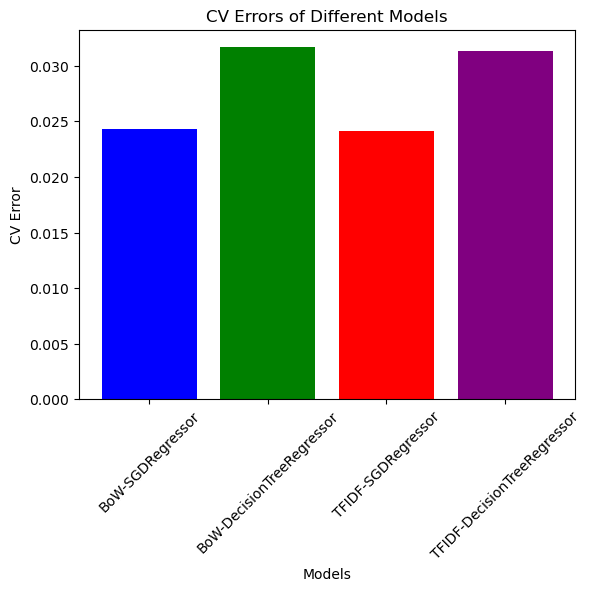

In [25]:
cv_errors = {
    'BoW-SGDRegressor': 0.02429,
    'BoW-DecisionTreeRegressor': 0.03166,
    'TFIDF-SGDRegressor': 0.02416,
    'TFIDF-DecisionTreeRegressor': 0.03138
}

fig, ax = plt.subplots()

models = list(cv_errors.keys())
errors = list(cv_errors.values())

ax.bar(models, errors, color=['blue', 'green', 'red', 'purple'])
ax.set_title('CV Errors of Different Models')
ax.set_xlabel('Models')
ax.set_ylabel('CV Error')

plt.xticks(rotation=45)
plt.show()